In [6]:
#imports
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import re

#load previously saved artifacts
tfidf = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/tfidf_vectorizer.joblib")
best_lr_l2 = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/logreg_l2_best.joblib")
best_lr_l1 = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/logreg_l1_best.joblib")
best_mlp   = joblib.load("../../../notebooks/artifacts/punctuation_no_stop_words/models/mlp_best.joblib")

#load data (same splits used earlier)
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

val = pd.read_csv(val_csv)
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

# preprocess (same method applied earlier)
# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

val['text_clean'] = val['Text'].apply(clean_data)
val = val.dropna(subset=['text_clean']).reset_index(drop=True)

X_val = tfidf.transform(val['text_clean'])
y_val = val['Label'].values
feature_names = tfidf.get_feature_names_out()

#target class names
class_names = ["Real", "Fake"]

c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danim\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.7.2. This might lead to b

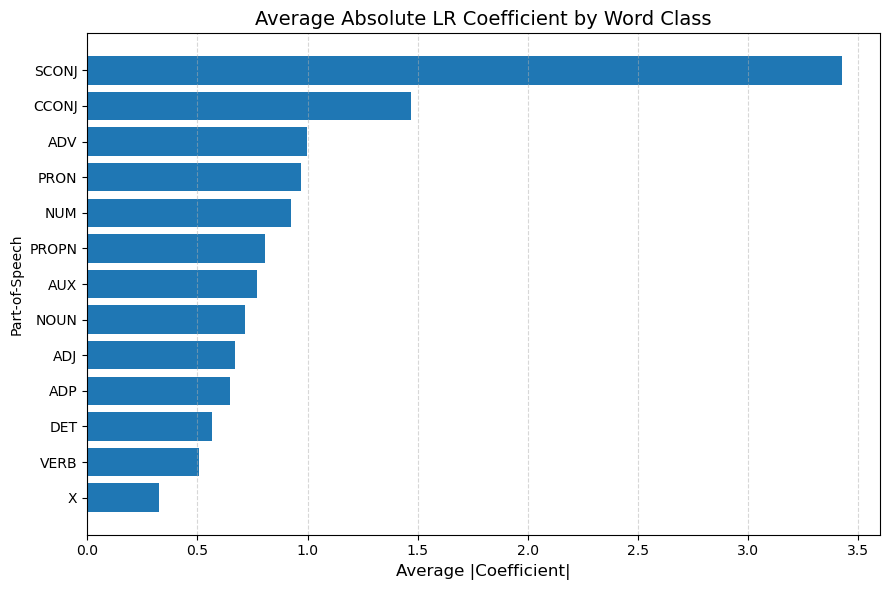

In [8]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Portuguese large model
nlp = spacy.load("pt_core_news_lg")

# Get LR weights
weights = best_lr_l1.coef_[0]

# Build dataframe with POS + absolute weight
data = []
for word, w in zip(feature_names, weights):
    doc = nlp(word)
    if len(doc) == 0:
        continue
    pos = doc[0].pos_
    data.append({
        "pos": pos,
        "abs_weight": abs(w)
    })

df = pd.DataFrame(data)

# Compute average absolute weight per POS
pos_summary = (
    df.groupby("pos")["abs_weight"]
      .mean()
      .sort_values(ascending=True)
)

# Plot
plt.figure(figsize=(9, 6))
plt.barh(pos_summary.index, pos_summary.values)

plt.title("Average Absolute LR Coefficient by Word Class", fontsize=14)
plt.xlabel("Average |Coefficient|", fontsize=12)
plt.ylabel("Part-of-Speech")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

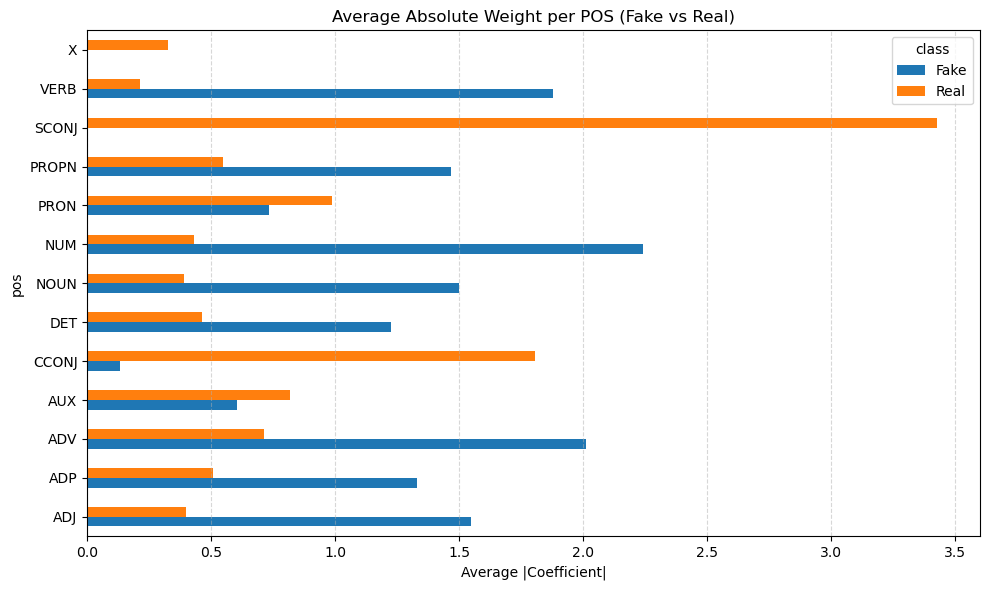

In [9]:
data = []

for word, w in zip(feature_names, weights):
    doc = nlp(word)
    if len(doc) == 0:
        continue
    pos = doc[0].pos_
    
    data.append({
        "pos": pos,
        "weight": w,
        "abs_weight": abs(w),
        "class": "Fake" if w > 0 else "Real"
    })

df_pos = pd.DataFrame(data)

# Mean positive and negative weight per POS
pos_class_summary = (
    df_pos.groupby(["pos", "class"])["abs_weight"]
    .mean()
    .unstack()
    .fillna(0)
)

pos_class_summary.plot(kind="barh", figsize=(10,6))
plt.title("Average Absolute Weight per POS (Fake vs Real)")
plt.xlabel("Average |Coefficient|")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()